In [42]:
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Populating the interactive namespace from numpy and matplotlib


C:\Users\User\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [121]:
from statsmodels.stats.weightstats import zconfint
from statsmodels.stats.proportion import proportion_confint

In [4]:
data = pd.read_csv('credit_card_default_analysis.csv')

In [7]:
pd.set_option('display.max_columns', 25)

In [16]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,0,0,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


control_median =  150000.0
test_median =  90000.0


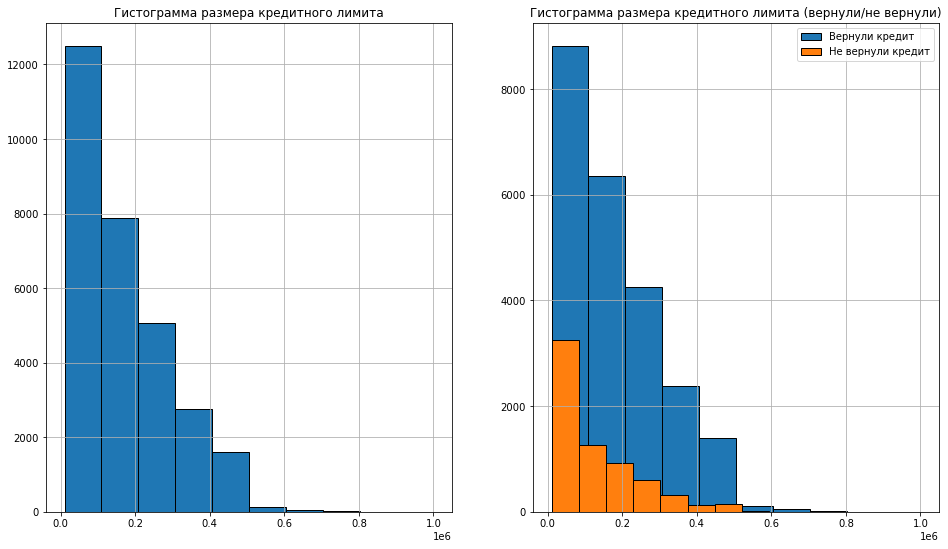

In [245]:
plt.figure(figsize=(16,9))
plt.subplot(121)
plt.title('Гистограмма размера кредитного лимита')
plt.hist(data['LIMIT_BAL'], edgecolor='k')
plt.grid()

# вернули кредит
control = data[data.default == 0]['LIMIT_BAL']
# control_median = np.median(control['LIMIT_BAL'])
print('control_median = ', control_median)

# не вернули кредит
test = data[data.default == 1]['LIMIT_BAL']
# test_median = np.median(test['LIMIT_BAL'])
print('test_median = ', test_median)

# медианы выборок различны, но это лишь грубое приближение

plt.subplot(122)
plt.title('Гистограмма размера кредитного лимита (вернули/не вернули)')
plt.hist(control, label='Вернули кредит', edgecolor='k')
plt.hist(test, label='Не вернули кредит', edgecolor='k')
plt.grid()
plt.legend()
plt.show()


In [112]:
# функция для построения доверительных интервалов для медиан (на основе распредления Бернулли)

# sample = control
# alpha = 0.05
# p = 0.5

def my_binom_zconfint(sample, p, alpha=0.05):
    q = 1 - p
    n = len(sample)
    mean = n*p
    variance = n*p*q
    z = z = stats.norm.ppf(1 - alpha/2.)
    low_number = int(round(mean - z*np.sqrt(variance)))
    low = np.sort(sample)[low_number]
    high_number = int(round(mean + z*np.sqrt(variance)))
    high =  np.sort(sample)[high_number]
    return low, high


In [114]:
# 1a) получим интервальные оценки медианных значений выборок критерием знаков на основе биноминальног распределения

interval = my_binom_zconfint(control, 0.5)
print('Доверительный интервал для медианы среди вернувших кредит:')
print('[{}; {}]'.format(interval[0], interval[1]))

interval = np.round(my_binom_zconfint(test, 0.5))
print('Доверительный интервал для медианы среди не вернувших кредит:')
print('[{}; {}]'.format(interval[0], interval[1]))

# доверительные интервалы для медиан значительно различаются

Доверительный интервал для медианы среди вернувших кредит:
[150000; 150000]
Доверительный интервал для медианы среди не вернувших кредит:
[80000; 90000]


In [69]:
# 1b) выборки имеют разный размер, поэтому будем использовать непараметрический критерий Манна-Уитни
res = stats.mannwhitneyu(control, test)
print(res)
print('p-value = ', res[1])
# значение p-value значительно меньше порога, поэтому нулевая гипотеза отвергается, а значит распределения выборок различны

# полученный результат значим, так как медианы значительно отличаются

MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)
p-value =  6.127742909111652e-190


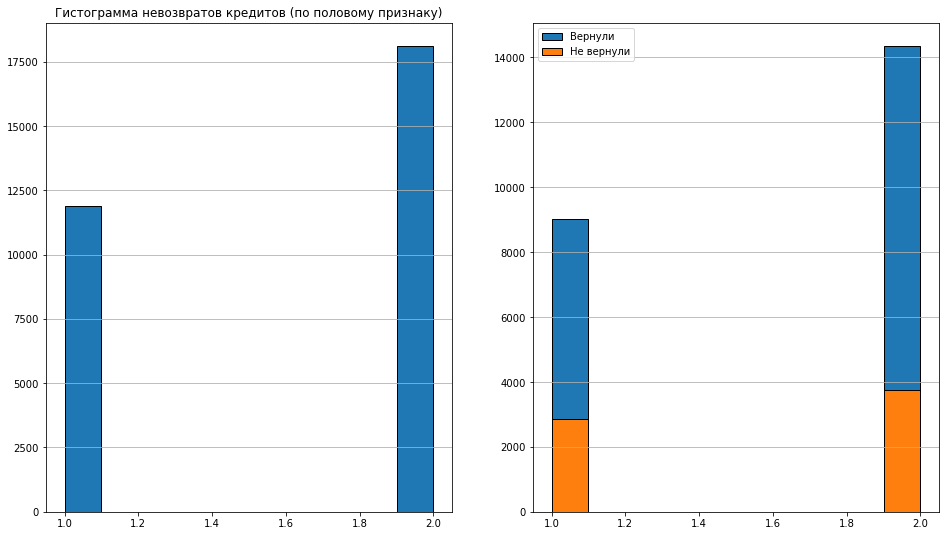

In [244]:
# 2) анализ гендерных различий среди вернувших и не вернувших кредит

plt.figure(figsize=(16,9))
subplot(121)
plt.title('Половая гистограмма заёмщиков')
plt.hist(data.SEX, edgecolor='k')
plt.grid(axis='y')
# мужчины
men = data[data.SEX == 1]['default']

# женщины
women = data[data.SEX == 2]['default']

plt.title('Гистограмма невозвратов кредитов (по половому признаку)')
plt.subplot(122)
plt.hist(data.SEX[data.default == 0], label='Вернули', edgecolor='k')
plt.hist(data.SEX[data.default == 1], label='Не вернули', edgecolor='k')
plt.grid(axis='y')
plt.legend()
plt.show()

# визуально женщины реже не возвращают кредиты

In [134]:
# вернули
sample = np.abs(data.SEX[data.default == 0] - 2)
interval = np.round(proportion_confint(count=sum(sample), nobs=len(sample),
                                     method='wilson'),4)

print('Доверительный интервал для доли мужчин среди вернувших:')
print('[{}; {}]'.format(interval[0], interval[1]))

# женщины
sample = np.abs(data.SEX[data.default == 1] - 2) 
interval = np.round(proportion_confint(count=sum(sample), nobs=len(sample),
                                     method='wilson'),4)
print('Доверительный интервал для доли мужчин среди не вернувших:')
print('[{}; {}]'.format(interval[0], interval[1]))

Доверительный интервал для доли мужчин среди вернувших:
[0.3796; 0.3921]
Доверительный интервал для доли мужчин среди не вернувших:
[0.4211; 0.4449]


In [135]:
# функция для построения доверительного интервала разности долей двух независимых выборок

def my_proportions_confint_diff_ind(sample1, sample2, alpha=0.05):
    n1 = len(sample1)
    n2 = len(sample2)
    p1 = float(sum(sample1)/n1)
    p2 = float(sum(sample2)/n2)
    z = stats.norm.ppf(1-alpha/2.)
    low = p1-p2 - z*sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)
    high = p1-p2 + z*sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)
    return low, high


In [137]:
sample1 = np.abs(data.SEX[data.default == 0] - 2) 
sample2 = np.abs(data.SEX[data.default == 1] - 2) 

interval = np.round(my_proportions_confint_diff_ind(sample1, sample2, alpha=0.05),4)

print('Доверительный интервал разности долей мужчин среди вернувших и не вернувших:')
print('[{}; {}]'.format(interval[0], interval[1]))

# разность долей значительная, учитывая специфику задачи банковского скоринга

Доверительный интервал разности долей мужчин среди вернувших и не вернувших:
[-0.0605; -0.0336]


In [143]:
# 2) анализ гендерных различий среди вернувших и не вернувших кредит (Z-критерий)

sample1 = np.abs(data.SEX[data.default == 0] - 2) 
sample2 = np.abs(data.SEX[data.default == 1] - 2) 


In [146]:
# функция для вычисления Z-статистика для независимых выборок

def my_proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    p1 = sum(sample1) / n1
    n2 = len(sample2)
    p2 = sum(sample2) / n2
    P = (p1 * n1 + p2 * n2) / (n1 + n2)
    z_stat = (p1 - p2) / np.sqrt(P * (1 - P) * (1 / n1 + 1 / n2))
    return z_stat

In [148]:
z_stat = my_proportions_diff_z_stat_ind(sample1, sample2)
p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))
print('p-value = ', p_value)

# значение p-value значительно меньше порога, поэтому нулевая гипотеза отвергается, а значит распределения выборок различны
# результат статистически значим, потому что разность долей может достигать 6%

p-value =  4.472866521609831e-12


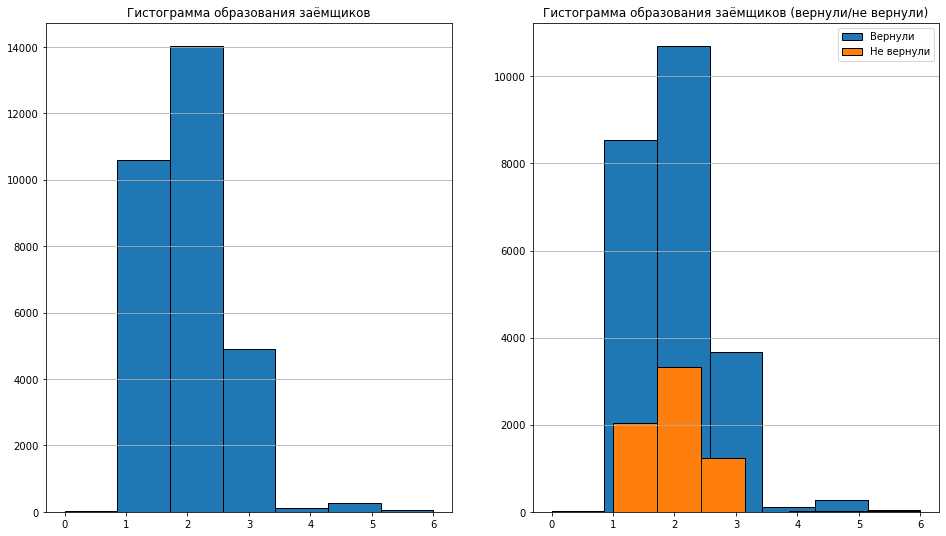

In [243]:
# 3) проверим гипотезу об одинаковом распределении образования среди вернувших и не вернувших кредит

plt.figure(figsize=(16,9))
subplot(121)
plt.title('Гистограмма образования заёмщиков')
plt.hist(data.EDUCATION, bins=7, edgecolor='k')
plt.grid(axis='y')

subplot(122)
plt.title('Гистограмма образования заёмщиков (вернули/не вернули)')
plt.hist(data.EDUCATION[data.default == 0], label='Вернули', bins=7, edgecolor='k')
plt.hist(data.EDUCATION[data.default == 1], label='Не вернули', bins=7,  edgecolor='k')
plt.legend()
plt.grid(axis='y')
plt.show()

# на основе визуальных данных видно, что кредиты берут преимущественно магистры, бакалвры и выпускники школ.
# разница в распределении образования среди вернувших и не вернувших кредит не наблюдается

In [195]:
proportions = []

for edu in range(data.EDUCATION.value_counts().shape[0]):
#     print(data[(data.EDUCATION == edu & data.default == 1)])
    def_0 = data[(data.EDUCATION == edu) & (data.default == 0)].shape[0]
    alls = data[data.EDUCATION == edu].shape[0]
    prop = def_0/alls
    print('Уровень образования "{}", доля возвратов: {}%'.format(edu, round(prop*100,1)))
    proportions.append(prop)

Уровень образования "0", доля возвратов: 100.0%
Уровень образования "1", доля возвратов: 80.8%
Уровень образования "2", доля возвратов: 76.3%
Уровень образования "3", доля возвратов: 74.8%
Уровень образования "4", доля возвратов: 94.3%
Уровень образования "5", доля возвратов: 93.6%
Уровень образования "6", доля возвратов: 84.3%


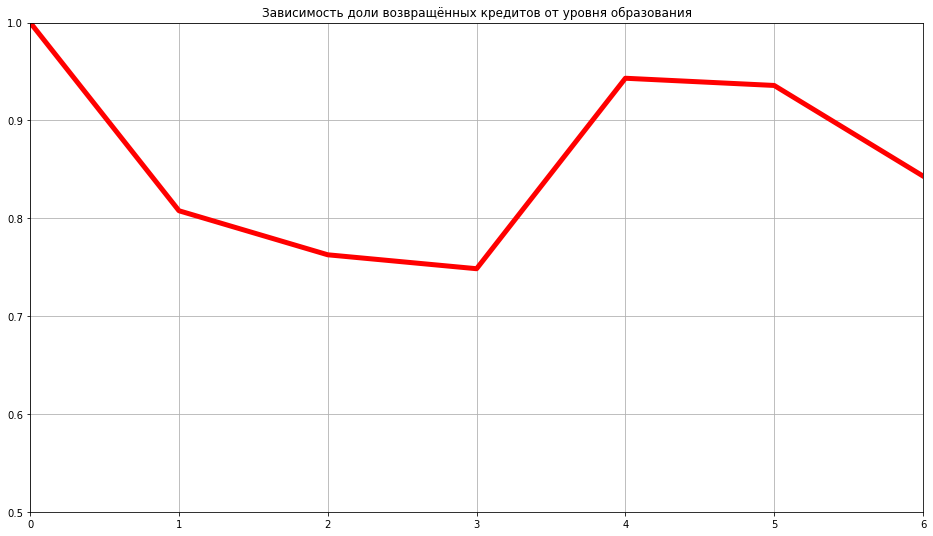

In [193]:
plt.figure(figsize=(16,9))
plt.title('Зависимость доли возвращённых кредитов от уровня образования')
plt.plot(proportions, linewidth=5, color='r')
plt.grid()
plt.axis([0, 6, 0.5, 1])
plt.show()

# из нашей выборки, чаще всего (100% случаев) возращают люди с докторской степенью, реже всего (74,8% случаев) - выпускники школ
# распределение не выглядит равномерным, можно ожидать, что образование влияет на возврат кредита, но только после строгой проверки

In [204]:
print('Средняя доля возвратов: {}% \n'.format(round(np.mean(proportions)*100),1))

for edu in range(data.EDUCATION.value_counts().shape[0]):
    def_0 = data[(data.EDUCATION == edu) & (data.default == 0)].shape[0]
    alls = data[data.EDUCATION == edu].shape[0]
    print('Уровень образования "{}":'.format(edu))
    print('\t', '{} - всего'.format(alls))
    print('\t', '{} - вернули'.format(def_0))
    print('\t', '{} - не вернули'.format(alls - def_0))

Средняя доля возвратов: 86% 

Уровень образования "0":
	 14 - всего
	 14 - вернули
	 0 - не вернули
Уровень образования "1":
	 10585 - всего
	 8549 - вернули
	 2036 - не вернули
Уровень образования "2":
	 14030 - всего
	 10700 - вернули
	 3330 - не вернули
Уровень образования "3":
	 4917 - всего
	 3680 - вернули
	 1237 - не вернули
Уровень образования "4":
	 123 - всего
	 116 - вернули
	 7 - не вернули
Уровень образования "5":
	 280 - всего
	 262 - вернули
	 18 - не вернули
Уровень образования "6":
	 51 - всего
	 43 - вернули
	 8 - не вернули


In [219]:
mean_prop = np.mean(proportions)
proportions_exp = []
proportions_obs = []

for edu in range(data.EDUCATION.value_counts().shape[0]):
    def_0 = data[(data.EDUCATION == edu) & (data.default == 0)].shape[0]
    alls = data[data.EDUCATION == edu].shape[0]
    expect = alls*mean_prop
    proportions_exp.append(expect)
    proportions_obs.append(def_0)
    print('Уровень образования "{}":'.format(edu))
    print('\t', '{} - вернули (налбюдение)'.format(def_0))
    print('\t', '{} - не вернули (ожидание)'.format(int(round(expect,0))))
    print('\t', '{} - разность наблюдения и ожидания'.format(int(def_0 - expect)))

Уровень образования "0":
	 14 - вернули (налбюдение)
	 12 - не вернули (ожидание)
	 1 - разность наблюдения и ожидания
Уровень образования "1":
	 8549 - вернули (налбюдение)
	 9134 - не вернули (ожидание)
	 -585 - разность наблюдения и ожидания
Уровень образования "2":
	 10700 - вернули (налбюдение)
	 12107 - не вернули (ожидание)
	 -1407 - разность наблюдения и ожидания
Уровень образования "3":
	 3680 - вернули (налбюдение)
	 4243 - не вернули (ожидание)
	 -563 - разность наблюдения и ожидания
Уровень образования "4":
	 116 - вернули (налбюдение)
	 106 - не вернули (ожидание)
	 9 - разность наблюдения и ожидания
Уровень образования "5":
	 262 - вернули (налбюдение)
	 242 - не вернули (ожидание)
	 20 - разность наблюдения и ожидания
Уровень образования "6":
	 43 - вернули (налбюдение)
	 44 - не вернули (ожидание)
	 -1 - разность наблюдения и ожидания


In [221]:
# используем критерий Пирснона (кси-квадрат), чтобы сделать вывод о нормальности распределения доли возвращаемых кредитов от уровня образования

res = stats.chisquare(f_obs=proportions_obs, f_exp=proportions_exp, ddof=1)
print('p-value = ', res[1])

# уровень значимости значительно ниже порога, значит нулевая гипотеза отвергается, вероятность возврата кредита зависит от образования

# результат статистически значим, так как наблюдаемы вероятности возврата внутри групп, разделённых по уровню образования отличаются значительно

p-value =  3.653181595163598e-58


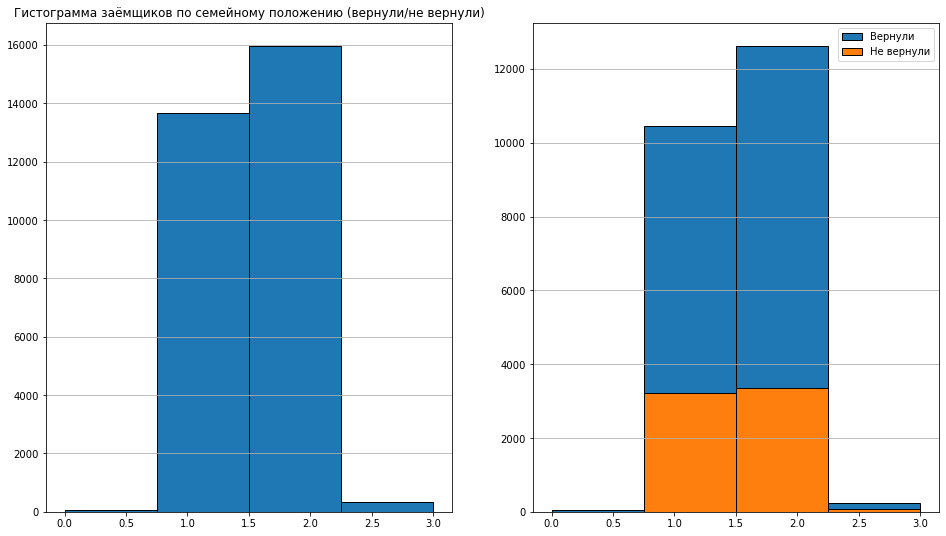

In [242]:
# 4) влияние семейного положение на возврат/не возврат кредита

plt.figure(figsize=(16,9))
subplot(121)
plt.title('Гистограмма заёмщиков по семейному положению')
plt.hist(data.MARRIAGE, bins=4, edgecolor='k')
plt.grid(axis='y')


plt.subplot(122)
plt.title('Гистограмма заёмщиков по семейному положению (вернули/не вернули)')
plt.hist(data.MARRIAGE[data.default == 0], bins=4, label='Вернули', edgecolor='k')
plt.hist(data.MARRIAGE[data.default == 1], bins=4, label='Не вернули', edgecolor='k')
plt.grid(axis='y')
plt.legend()
plt.show()

# ожидаемо, большинство людей женаты/замужем или холосты.
# почти одинаковое количество (абсолютное) невозвратов среди женатых/замужних и холостых, при этом последних заметно больше

In [254]:
# для нахождения взаимосвязи между категориальными признаками воспользуемся коэффициентом V Крамера

table = np.zeros((data.MARRIAGE.value_counts().shape[0], data.default.value_counts().shape[0]))

for x in range(data.default.value_counts().shape[0]):
    for y in range(data.MARRIAGE.value_counts().shape[0]):
        control = data[(data.default == x) & (data.MARRIAGE == y)]
        table[y,x] = control.shape[0]
        
print('Построим таблицу сопряженности:')
print(table)

Построим таблицу сопряженности:
[[4.9000e+01 5.0000e+00]
 [1.0453e+04 3.2060e+03]
 [1.2623e+04 3.3410e+03]
 [2.3900e+02 8.4000e+01]]


In [263]:
# функция для расчёта коэффициента V Крамера по таблице сопряженности

def my_v_cramer(table):
    K1 = table.shape[0]
    K2 = table.shape[1]
    N = np.sum(table)
    minK = min(K1, K2)
    chi2 = stats.chi2_contingency(table)[0]
    return np.sqrt(chi2 / (N*(minK-1)))


In [264]:
print('Коэффициент V Крамера: ', round(my_v_cramer(table),4))

# значение коэффициента близко к нулю, значит взаимосвязь отсутствует
# практическая значимость состоит в отсутствии влияния семейного положения на вероятность возврата кредита

Коэффициент V Крамера:  0.0345


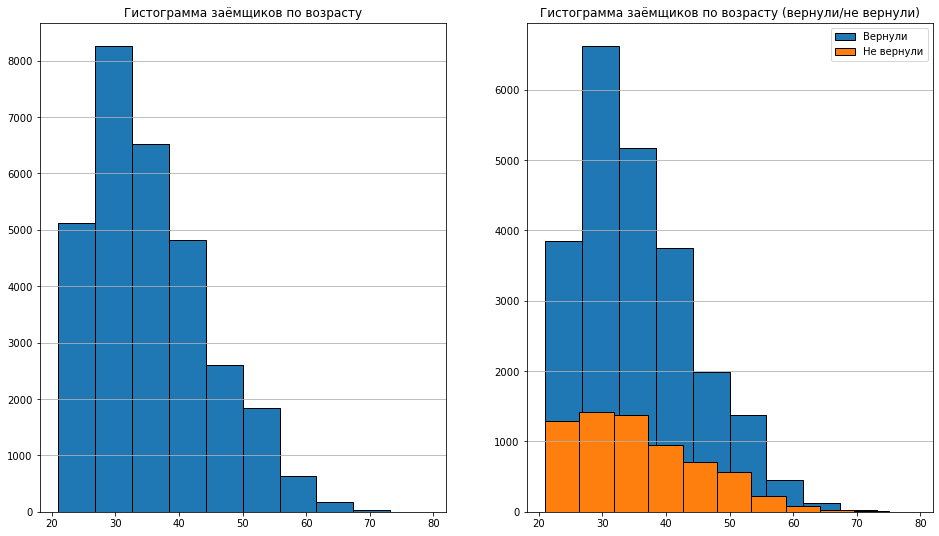

In [268]:
# 5) влияние возраста на возврат/не возврат кредита

plt.figure(figsize=(16,9))
subplot(121)
plt.title('Гистограмма заёмщиков по возрасту')
plt.hist(data.AGE, edgecolor='k')
plt.grid(axis='y')


plt.subplot(122)
plt.title('Гистограмма заёмщиков по возрасту (вернули/не вернули)')
plt.hist(data.AGE[data.default == 0], label='Вернули', edgecolor='k')
plt.hist(data.AGE[data.default == 1], label='Не вернули', edgecolor='k')
plt.grid(axis='y')
plt.legend()
plt.show()